# Using ADQL to Search for Bright Stars Around the Open Cluster Ruprecht 147

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

Downloading stars from Gaia DR3 as specified:

In [2]:
from astroquery.gaia import Gaia

# writing query
query = """
    SELECT
        g.source_id, g.ra, g.dec,
        g.parallax, tm.ph_qual,
        g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
        tm.j_m, tm.ks_m, tm.h_m
    FROM gaiadr3.gaia_source AS g
    JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
    JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
    JOIN gaiadr1.tmass_original_valid AS tm ON
        xjoin.original_psc_source_id = tm.designation
    WHERE
        g.phot_g_mean_mag <= 14 AND
        CONTAINS(POINT('ICRS', g.ra, g.dec),
                 CIRCLE('ICRS', 289.074, -16.323, 1.0)
                 ) = 1;
"""

# launching job
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


Determining number of stars returned from initial query:

In [3]:
n_init = len(df)
print(f"{n_init} stars returned from initial query")

3637 stars returned from initial query


Identifying stars with bad 2MASS photometry:

In [4]:
bad_phot = df[df['ph_qual'] != 'AAA']
print(f"{len(bad_phot)} stars with bad 2MASS photometry:")
print(np.array(bad_phot['source_id']))

79 stars with bad 2MASS photometry:
[4087817587345358208 4088030720802935168 4087828449329195776
 4087831988382289792 4087832194541999104 4088035909118412800
 4087842193224785664 4087844254808918144 4087851951390671616
 4087852569865828480 4087853325780080128 4088047453989773696
 4088049451167613056 4088052577903809024 4088058350339740800
 4088062336069424000 4087732791815017600 4088087934075314688
 4088005401981875584 4087744439766863488 4088010757794954368
 4087746879307955840 4088013442160554368 4088014709166994176
 4087748524273962368 4087748524281168896 4087759832930186624
 4087760279606644864 4087762272471851648 4087764948221782656
 4087775466611402368 4087778009231713408 4087778662066743040
 4087786560496352256 4087797452538681728 4087798792568475776
 4087799823360628096 4084761464720609664 4084764007335277184
 4183926109191842304 4183926418429491072 4183931125713344640
 4183933256017241984 4183933354788787968 4183936795070404352
 4183939956166357888 4183942052110257536 41839420

Identifying stars with non-positive parallaxes:

In [5]:
bad_parallax = df[df['parallax'] <= 0]
print(f"{len(bad_parallax)} stars with non-positive parallaxes:")
print(np.array(bad_parallax['source_id']))

5 stars with non-positive parallaxes:
[4088071681918475648 4183955761646427648 4184125666248287232
 4183866323248161280 4184214387399231360]


Applying quality cuts:

In [6]:
df_clean = df.drop(bad_phot.index).drop(bad_parallax.index)
n_clean = len(df_clean)
print(f"Quality cuts applied. Clean dataset stored as df_clean with {n_clean} stars remaining.")

Quality cuts applied. Clean dataset stored as df_clean with 3553 stars remaining.


Generating and saving figure as specified:

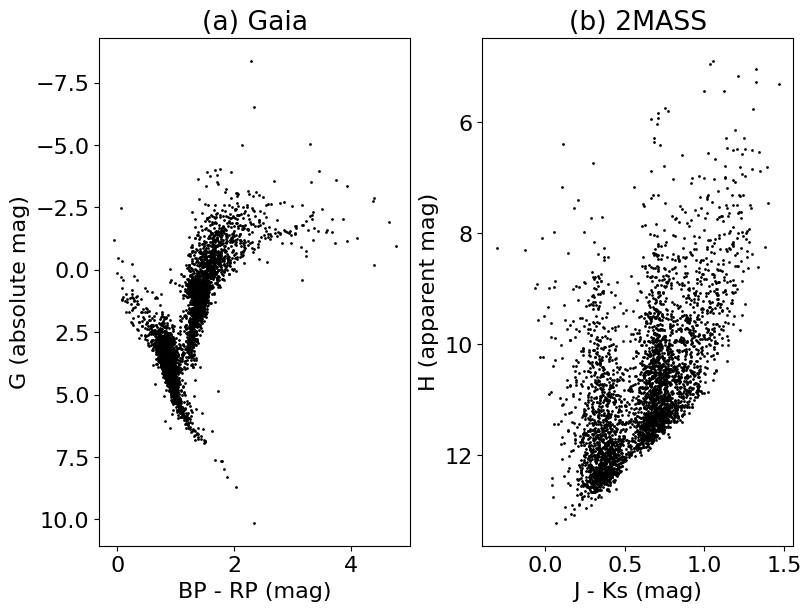

In [7]:
# find absolute G magnitude
df_clean['abs_g'] = df_clean['phot_g_mean_mag'] + 5 * np.log10(df_clean['parallax']/1000.0) + 5
# find BP-RP color
df_clean['bp_rp'] = df_clean['phot_bp_mean_mag'] - df_clean['phot_rp_mean_mag']
# find J-Ks color
df_clean['j_ks'] = df_clean['j_m'] - df_clean['ks_m']

# plotting
fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].scatter(df_clean['bp_rp'], df_clean['abs_g'], s=1, color='black')
ax[0].set_xlabel('BP - RP (mag)')
ax[0].set_ylabel('G (absolute mag)')
ax[0].set_title('(a) Gaia')
ax[0].invert_yaxis()

ax[1].scatter(df_clean['j_ks'], df_clean['h_m'], s=1, color='black')
ax[1].set_xlabel('J - Ks (mag)')
ax[1].set_ylabel('H (apparent mag)')
ax[1].set_title('(b) 2MASS')
ax[1].invert_yaxis()

# save figure
plt.savefig('figures/cmds_R417.png', dpi=200)

2dF has a maximum of 392 science fibres that can be used simultaneously, meaning that up to 392 spectra can be observed at a time within a 2-degree field (from the [user guide](https://aat.anu.edu.au/files/2dF-AAOmega-obs-manual_3.pdf)). This project would involve the observation of 3553 stars, meaning that each fibre would be well-utilised. This proposal is therefore well-supported in terms of fibre usage, as every fibre would be assigned a target multiple times over the course of this study.